In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# _Indlæsning af data_

### GRACE

In [67]:
råsatellit = pd.read_csv('greenland_mass_200204_202311-kopi.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

### GRIP, NGRIP

In [68]:
råNGRIP = pd.read_excel('NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010-kopi.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010-kopi.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]

In [69]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2 # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


### DMI

In [70]:
rådata = pd.read_excel('DailyMinMax_Ilullisat_Cor-kopi.xlsx')
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

#### _Interpolering af DMI-data_

In [71]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []

    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)
    
    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])

    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    
    return år
    
år_DMI_inter = interpolation_år()     # Interpolerer temperaturdataen
år_DMI_inter = np.array(år_DMI_inter)

temp_DMI_inter = np.interp(år_DMI_inter, år_rå, temp_rå)

### Slicing af DMI-/ og GRACE-data

In [72]:
top = max(år_sat)   
bund = min(år_sat)

# Slicing af DMI-data
temp_DMI = temp_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år_DMI = år_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år_DMI)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

# Funktion der bestemmer k_acc fra værdi af M_akk

In [73]:
M_akk_mean = 642 * 10**12 # kg nedbør
M_akk_std = 59 * 10**12 # kg

In [82]:
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit

def optimering_akk(M_akk_tabel):

    V_start = 2.99 * 10**15   # startvolumen af iskappe
    H = 3 * 10**3       # starthøjde af iskappe
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    V_sat = dvol_sat + V_0 - dvol_sat[0]
    
    R = (3/16*V/H)**(1/2)    # startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k_0 = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # tidsskridt (her 1/4 døgn) - omregnet til år

    acc = akk_gns   # nedbør pr år [m/år]. Antages konstant i perioden
    k_acc_test = 1   # denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
    k_melt = 1

    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []

    for i in range(len(år_DMI)):
        R = (3/16 * V/k_0)**(2/5)     # Ny radius af iskappe
       
        V_acc = k_acc_test * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
       
        if temp_DMI[i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[i] - T_f) * ((T_f - temp_DMI[i])/(alfa * k_0))**2 * dt  # ganger tidsskridt og M på
        V += V_acc - V_melt

        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)

   
    V_sum = np.sum(V_acc_list)/(år_DMI[-1] - år_DMI[0])
    V_akk_tabel = (M_akk_tabel)/(densitet_is) # m^3

    k_acc = V_akk_tabel/V_sum
    
    return k_acc

In [83]:
# Laver optimering for gennemsnitligt akkumuleret nedbør
k_acc = optimering_akk(M_akk_mean)
print(k_acc)

2.30089779452381


# Simuleringsfunktion til bestemmelse af k_melt

In [84]:
V_start = 2.99 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(dvol_sat)/np.sqrt(len(dvol_sat)))**2)

def simulering(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    H = 3 * 10**3       # Starthøjde af iskappe
    R = (3/16*V/H)**(1/2)     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k_0 = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år_DMI) + 1):
        R = (3/16 * V/k_0)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_DMI[-i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[-i] - T_f) * ((T_f - temp_DMI[-i])/(alfa * k_0))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år_DMI, dvol_sim)

    return dvol_sim_fit

# Optimal k_melt for k_acc

In [85]:
par, cov = curve_fit(simulering, år_sat, dvol_sat_korr, p0 = 7, sigma = dvol_sat_err_korr, absolute_sigma= True)

k_melt = par
dk_melt = np.sqrt(np.diag(cov))

print(k_melt)
print(dk_melt)

[8.15302445]
[0.01330551]


In [86]:
V_start = 2.99 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(dvol_sat)/np.sqrt(len(dvol_sat)))**2)

def simulering2(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    H = 3 * 10**3       # Starthøjde af iskappe
    R = (3/16*V/H)**(1/2)     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k_0 = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år_DMI) + 1):
        R = (3/16 * V/k_0)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_DMI[-i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[-i] - T_f) * ((T_f - temp_DMI[-i])/(alfa * k_0))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år_DMI, dvol_sim)

    return dvol_sim

In [87]:
test2 = simulering2(år_sat, 8.15302445)

# Plot

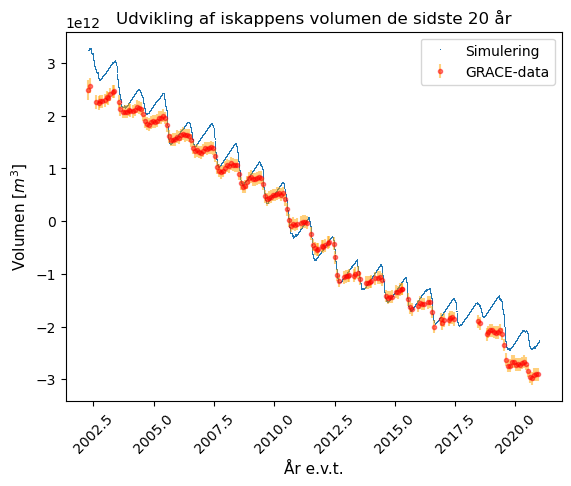

In [90]:
test = simulering(år_sat, 8.15302445) # her simuleres til den optimale k_melt for den k_acc der findes, når vi bruger M_akk_mean

plt.plot(år_DMI, test2, ",", label = 'Simulering') # plot noget andet? det interpolerede data
plt.errorbar(år_sat, dvol_sat_korr, yerr = dvol_sat_err_korr, fmt = '.', ecolor = "orange", color = "red", alpha = 0.5, label = 'GRACE-data')
plt.xlabel("År e.v.t.", fontsize = 11)
plt.ylabel('Volumen $[m^3]$', fontsize = 11)
plt.xticks(rotation = 45)
plt.title('Udvikling af iskappens volumen de sidste 20 år')
plt.legend()